# 

only old behav_fit environments seem to work with model-fitting (behav_fit_2_clone)

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi
import arviz as az

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')
plot_folder = op.join(bids_folder, 'plots_and_ims', 'behavior_risk')

In [6]:
from utils import get_data
import numpy as np
           
df = get_data()
df['x'] = df['log(risky/safe)'] 

group_list = df.reset_index().drop_duplicates(subset=['subject', 'group'])[['subject', 'group']]

number of subjects found: 64


In [7]:
model_label = 1

if model_label == 1:
    model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())

#model = bambi.Model('chose_risky ~ x + (x|subject)', link='probit', family='bernoulli', data=df.reset_index().mapper)
#model = bambi.Model('chose_risky ~ x + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())
#model = bambi.Model('chose_risky ~ x', link='probit', family='bernoulli', data=df.reset_index())


In [ ]:
format = 'symbolic'
model_label = 2

data = df.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=data.reset_index())

### fit RNP via bambi

In [9]:
traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

az.to_netcdf(traces, op.join(target_folder, f'rnp_model-{model_label}_trace.netcdf'))

Modeling the probability that chose_risky==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, group, x:group, format, x:format, group:format, x:group:format, 1|subject_sigma, 1|subject_offset, x|subject_sigma, x|subject_offset, format|subject_sigma, format|subject_offset, x:format|subject_sigma, x:format|subject_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 734 seconds.


'/Users/mrenke/data/ds-dnumrisk/derivatives/cogmodels_risk/rnp_model-1_trace.netcdf'

## load in traces

In [8]:
model_label = 1

traces = az.from_netcdf(op.join(target_folder, f'rnp_model-{model_label}_trace.netcdf'))


#### Analyse traces/posteriors

Intercept: mean=-2.2332217868777224, 95%CI=[-2.59230424 -1.88010277]
x: mean=2.285436287907574, 95%CI=[1.9917473  2.59340646]
group: mean=0.46959136282598263, 95%CI=[-0.0223119  0.9857495]
x:group: mean=-0.46306681778448394, 95%CI=[-0.88826232 -0.03224004]
format: mean=-0.4645324281803913, 95%CI=[-0.66340588 -0.25877815]
x:format: mean=0.5993178704403843, 95%CI=[0.37315037 0.82902716]
group:format: mean=0.03023440671632332, 95%CI=[-0.2499409   0.31388737]
x:group:format: mean=-0.20336845437485057, 95%CI=[-0.51537844  0.10873211]


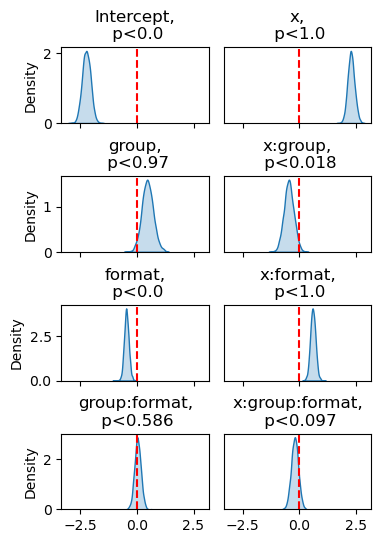

In [13]:
variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
variable_names = [x for x in variable_names if 'subject' not in x] # remove sd

n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(4,6), sharex=True)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=0.7)
plt.savefig(op.join(plot_folder, f'rnp_model-{model_label}_regressors.pdf'))

In [5]:
# intercept
df_i = traces.posterior['Intercept'].to_dataframe().join(traces.posterior['format'].to_dataframe().droplevel(2))
df_i = df_i.join(traces.posterior['group'].to_dataframe()).join(traces.posterior['group:format'].to_dataframe().droplevel(2))
df_i['control_nonsymb'] = df_i['Intercept']
df_i['control_symb'] = df_i['Intercept'] + df_i['format']
df_i['dyscalc_nonsymb'] = df_i['Intercept'] + df_i['group']
df_i['dyscalc_symb'] = df_i['Intercept'] + df_i['format'] + df_i['group'] + df_i['group:format']
df_i = df_i[['control_nonsymb', 'control_symb', 'dyscalc_nonsymb', 'dyscalc_symb']]
df_i = df_i.melt(var_name='group_format', value_name='intercept')
df_i[['group', 'format']] = df_i['group_format'].str.split('_', expand=True)

# gamma
df_g = traces.posterior['x'].to_dataframe().join(traces.posterior['x:format'].to_dataframe().droplevel(2))
df_g = df_g.join(traces.posterior['x:group'].to_dataframe()).join(traces.posterior['x:group:format'].to_dataframe().droplevel(2))
df_g['control_nonsymb'] = df_g['x']
df_g['control_symb'] = df_g['x'] + df_g['x:format']
df_g['dyscalc_nonsymb'] = df_g['x'] + df_g['x:group']
df_g['dyscalc_symb'] = df_g['x'] + df_g['x:format'] + df_g['x:group'] + df_g['x:group:format']
df_g = df_g[['control_nonsymb', 'control_symb', 'dyscalc_nonsymb', 'dyscalc_symb']]
df_g = df_g.melt(var_name='group_format', value_name='gamma')
df_g[['group', 'format']] = df_g['group_format'].str.split('_', expand=True)

# rnp
df_comb = df_g.set_index('group_format').join(df_i.set_index('group_format')['intercept'])
df_comb['rnp'] = np.clip(np.exp(df_comb['intercept']/df_comb['gamma']), 0, 1)
df_rnp = df_comb[['rnp','group','format']]

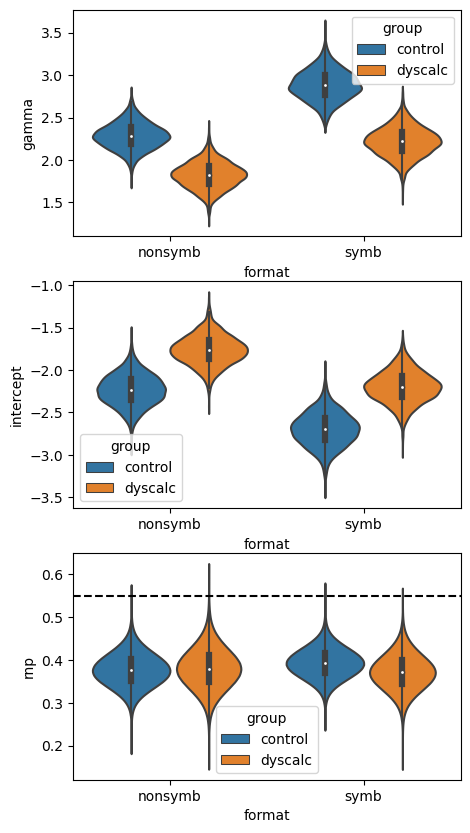

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(5,10))
sns.violinplot(data=df_g, x='format', y='gamma', hue='group', ax=axs[0])
sns.violinplot(data=df_i, x='format', y='intercept', hue='group', ax=axs[1])
sns.violinplot(data=df_rnp, x='format', y='rnp', hue='group', ax=axs[2])
axs[2].axhline(y=0.55, color='black', linestyle='--')

In [119]:
rnp_dif = np.asarray(df_comb[df_comb['group']=='control']['rnp'])  - np.asarray(df_comb[df_comb['group']=='dyscalc']['rnp'])
df_rnp_dif = pd.DataFrame(data=rnp_dif, index=df_comb[df_comb['group']=='control'].index).rename(mapper={0:'rnp_dif'},axis=1) #, columns='rnp_dif')
df_rnp_dif[['group', 'format']] = df_rnp_dif.reset_index()['group_format'].str.split('_', expand=True)

df_rnp_dif.head()


,rnp_dif,group,format
group_format,,,
control_nonsymb,0.048519,NaN,NaN
control_nonsymb,0.045226,NaN,NaN
control_nonsymb,0.013946,NaN,NaN
control_nonsymb,0.047648,NaN,NaN
control_nonsymb,0.001860,NaN,NaN


In [117]:
df_rnp_dif

,rnp_dif
group_format,
control_nonsymb,0.048519
control_nonsymb,0.045226
control_nonsymb,0.013946
control_nonsymb,0.047648
control_nonsymb,0.001860
...,...
control_symb,0.055220
control_symb,-0.011932
control_symb,0.026952


In [ ]:
df_g[['group', 'format']] = df_g['group_format'].str.split('_', expand=True)



In [ ]:
# takes super long somehow ....
fig, axs = plt.subplots(3, 1, figsize=(5,10))

for i, param in enumerate(['gamma', 'intercept', 'rnp']):
    sns.violinplot(data=df_comb, x='format', y=param, hue='group', ax=axs[i])

### subwise estimates

In [9]:
from utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, df, format = True, group=True)
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

In [54]:
target_folder = op.join(bids_folder, 'derivatives', 'phenotype')

rnp.groupby(['subject', 'format']).mean().to_csv(op.join(target_folder, 'rnp_sub-format-wise.csv'))

<Figure size 640x480 with 0 Axes>

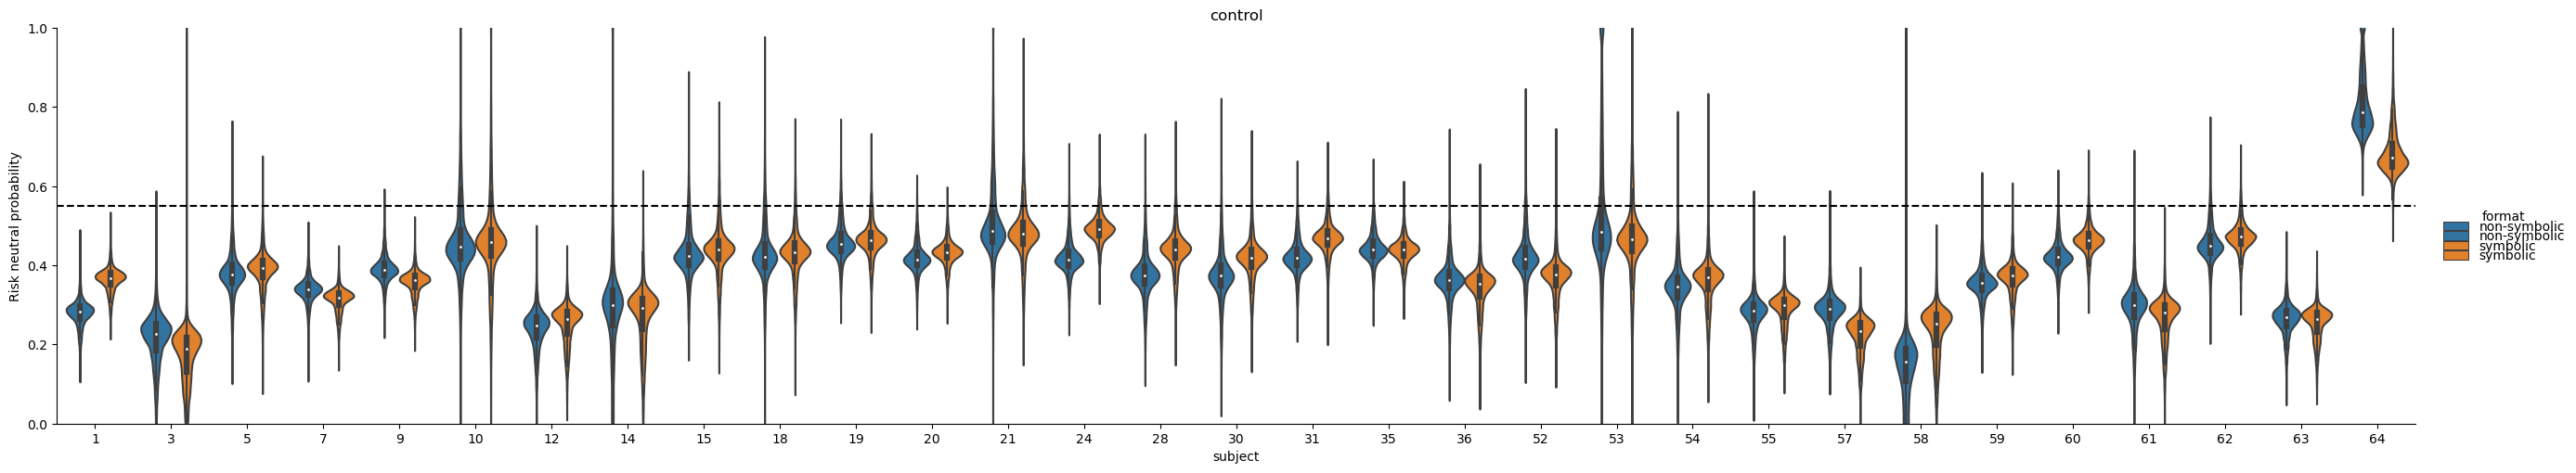

<Figure size 640x480 with 0 Axes>

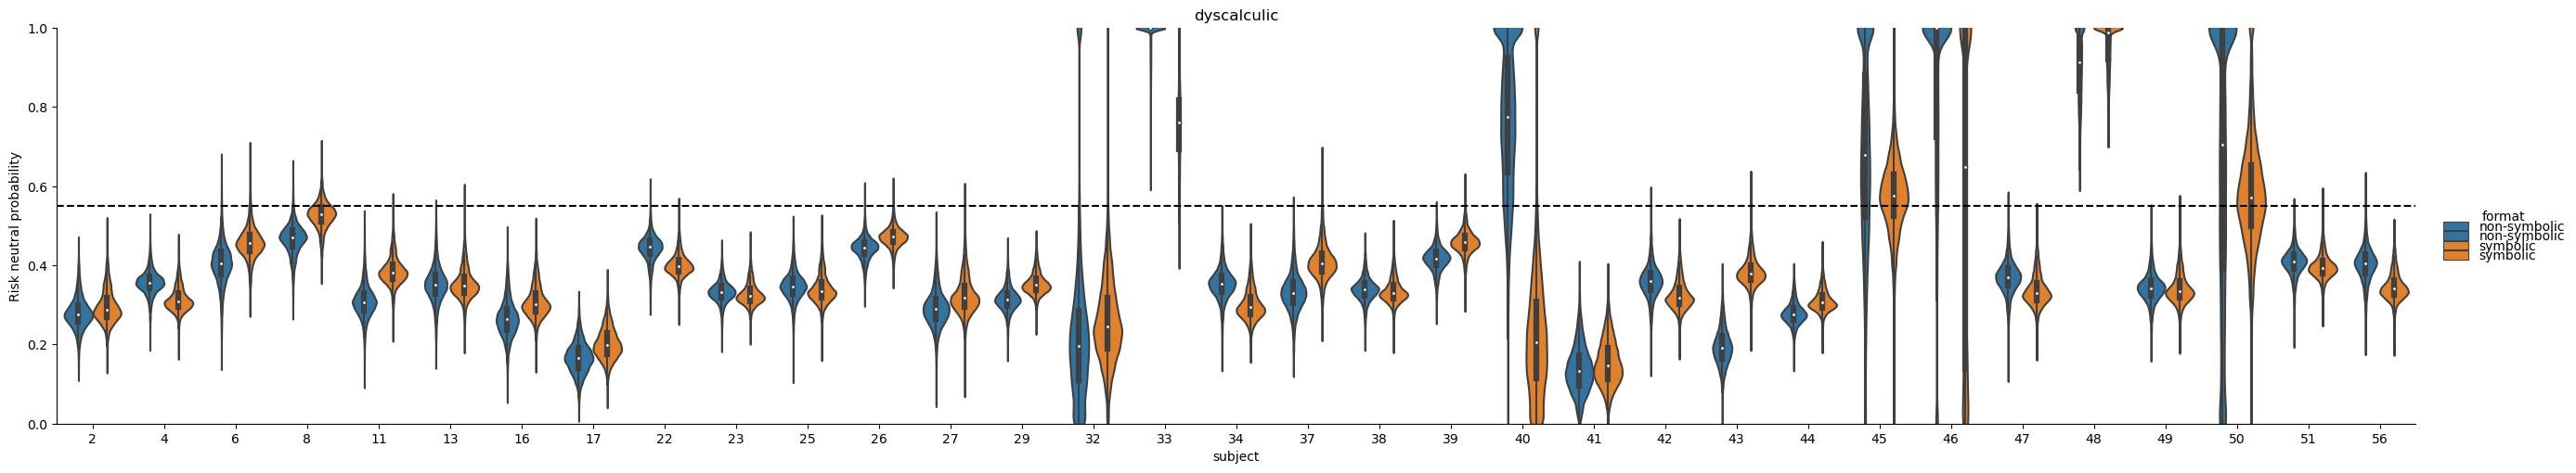

In [28]:
# RNP
for i, group in enumerate(['control','dyscalculic']):
    plt.figure()
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = rnp[rnp.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='rnp', data=temp.reset_index(), hue='format', aspect=5., kind='violin')
    plt.ylim(0, 1)
    plt.axhline(.55, c='k', ls='--', label='risk-neutral')
    fac.set(title=f'{group}', ylabel='Risk neutral probability')
    fac.add_legend()
    plt.savefig(op.join(plot_folder, f'rnp_model-{model_label}_subwise-rnps_group-{group}.pdf'))

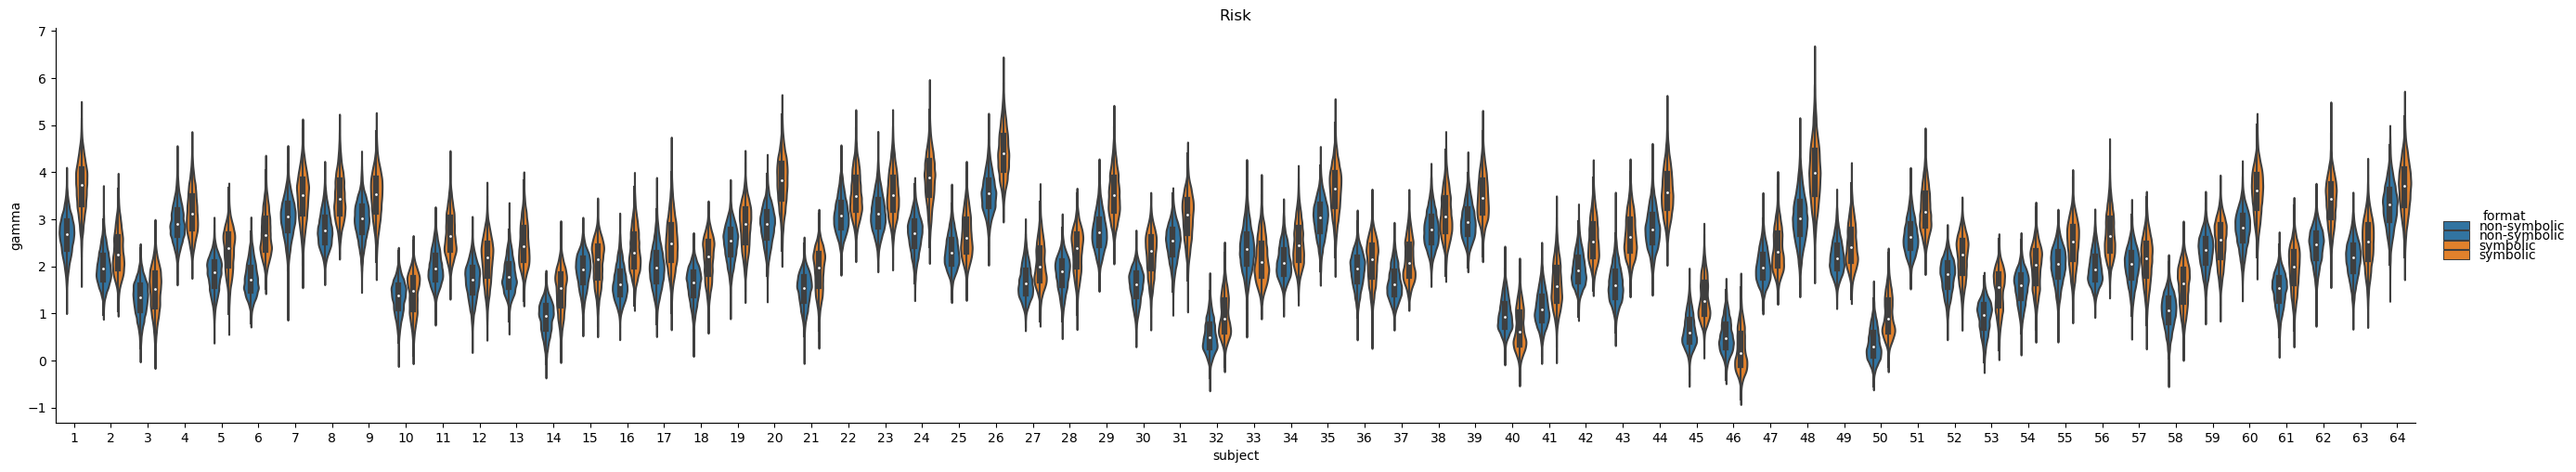

In [30]:
g = gamma.stack([1, 2])
g.columns = ['gamma']

fac = sns.catplot(x='subject', y='gamma', data=g.reset_index(), aspect=5., kind='violin', hue='format')
fac.set(title='Risk', ylabel='gamma')
fac.add_legend()

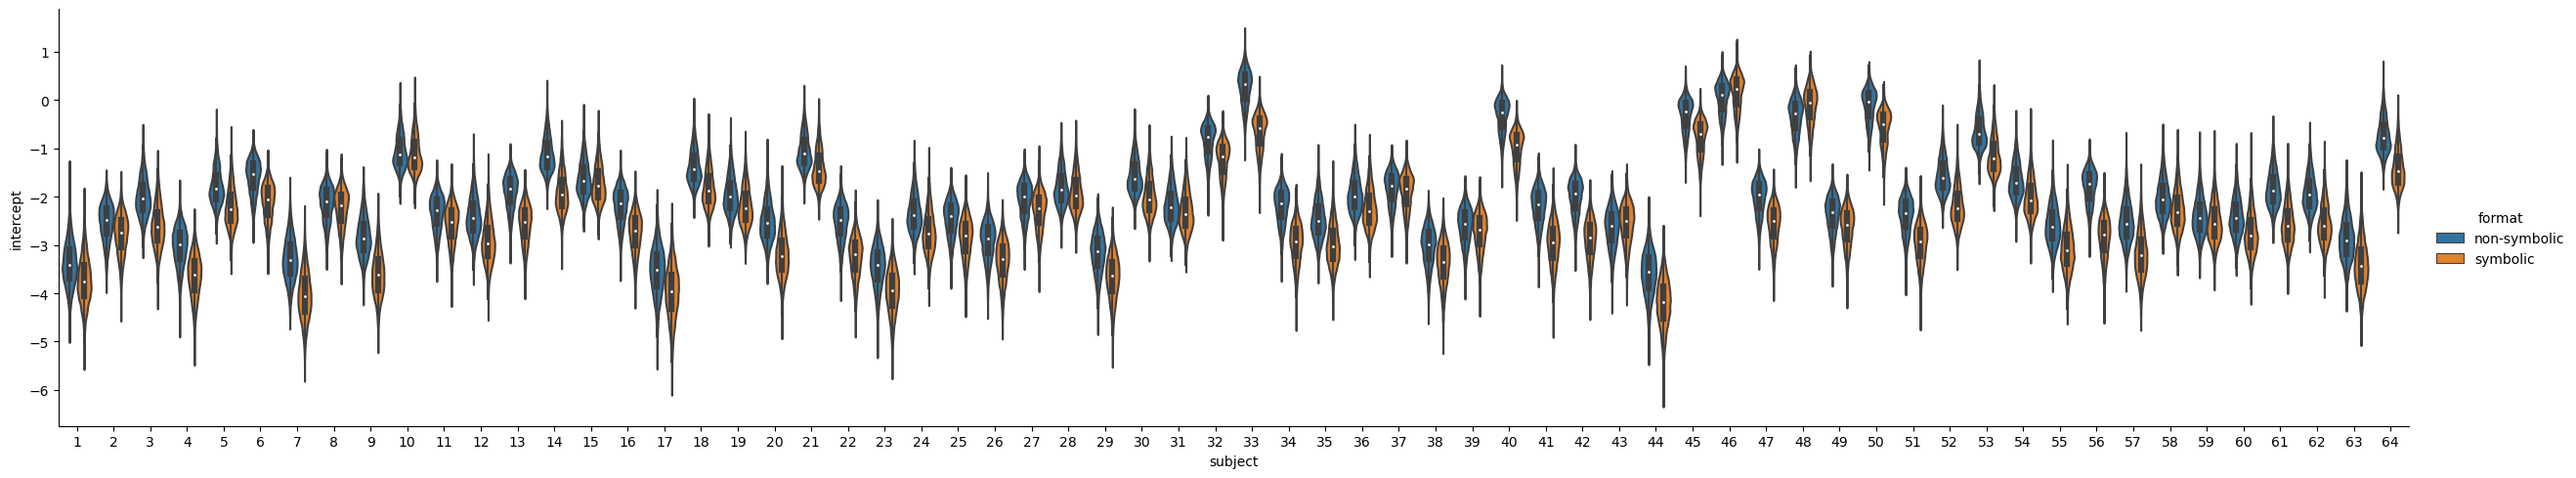

In [31]:
intercept = intercept.stack([1, 2])
intercept.columns = ['intercept']

fac = sns.catplot(x='subject', y='intercept', data=intercept.reset_index(), aspect=5., kind='violin', hue='format')

## PPC

In [ ]:
from utils_03 import format_bambi_ppc, summarize_ppc, plot_ppc

ppc = format_bambi_ppc(traces, model, df)

summarize_ppc(ppc, groupby=None)

plot_ppc(df, ppc,level='group')

### transform parameters into KLW model parameters (sd evi & prior)

In [ ]:
from utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, df, format = True, group=True)
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])

In [13]:
intercept_ar = np.asarray(intercept.stack([1,2]))
gamma_ar = np.asarray(gamma.stack([1,2]))


In [39]:
sd_ev = 1/(np.sqrt(2) * gamma_ar)
#sd_prior = np.sqrt( (- sd_ev/(np.sqrt(2) * np.log(0.55))) /  (intercept_ar + (1/ (np.sqrt(2) * sd_ev * np.log(0.55))) ) ) # tau
sd_prior = np.sqrt( (- sd_ev* np.log(1/.55)/(np.sqrt(2) )) /  (intercept_ar + (1 * np.log(1/.55)/ (np.sqrt(2) * sd_ev )) ) ) # tau
sd_prior

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_13970/3048223925.py:3: RuntimeWarning: invalid value encountered in sqrt
  sd_prior = np.sqrt( (- sd_ev* np.log(1/.55)/(np.sqrt(2) )) /  (intercept_ar + (1 * np.log(1/.55)/ (np.sqrt(2) * sd_ev )) ) ) # tau


array([[0.5070416 ],
       [0.50716992],
       [0.5687643 ],
       ...,
       [0.3374163 ],
       [0.34190468],
       [0.31394353]])

In [21]:
# sd_ev = 1/(np.sqrt(2) * gamma) # nu
# sd_prior = np.sqrt( (sd_ev/(np.sqrt(2) * np.log(0.55))) /  (intercept - (1/ (np.sqrt(2) * sd_ev * np.log(0.55))) ) ) # tau


/Users/mrenke/mambaforge/envs/behav_fit2_clone/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


In [44]:
len(sd_prior)

6144000

In [45]:
df_klw_params = pd.DataFrame(data={'sd_ev':sd_ev, 'sd_prior':sd_prior}, index=intercept.stack([1,2]).index)

In [48]:
df_klw_params#.groupby('subject').mean() 

sd_ev  sd_prior
subject n_safe format       group chain draw                    
13      7.0    non-symbolic 1     0     0     0.444703  0.507042
                                        1     0.421340  0.507170
                                        2     0.344625  0.568764
                                        3     0.364959  0.438283
                                        4     0.401227  0.521447
...                                                ...       ...
57      28.0   symbolic     0     3     995   0.234143  0.344186
                                        996   0.223843  0.299214
                                        997   0.227571  0.337416
                                        998   0.232936  0.341905
                                        999   0.232377  0.313944

[6144000 rows x 2 columns]

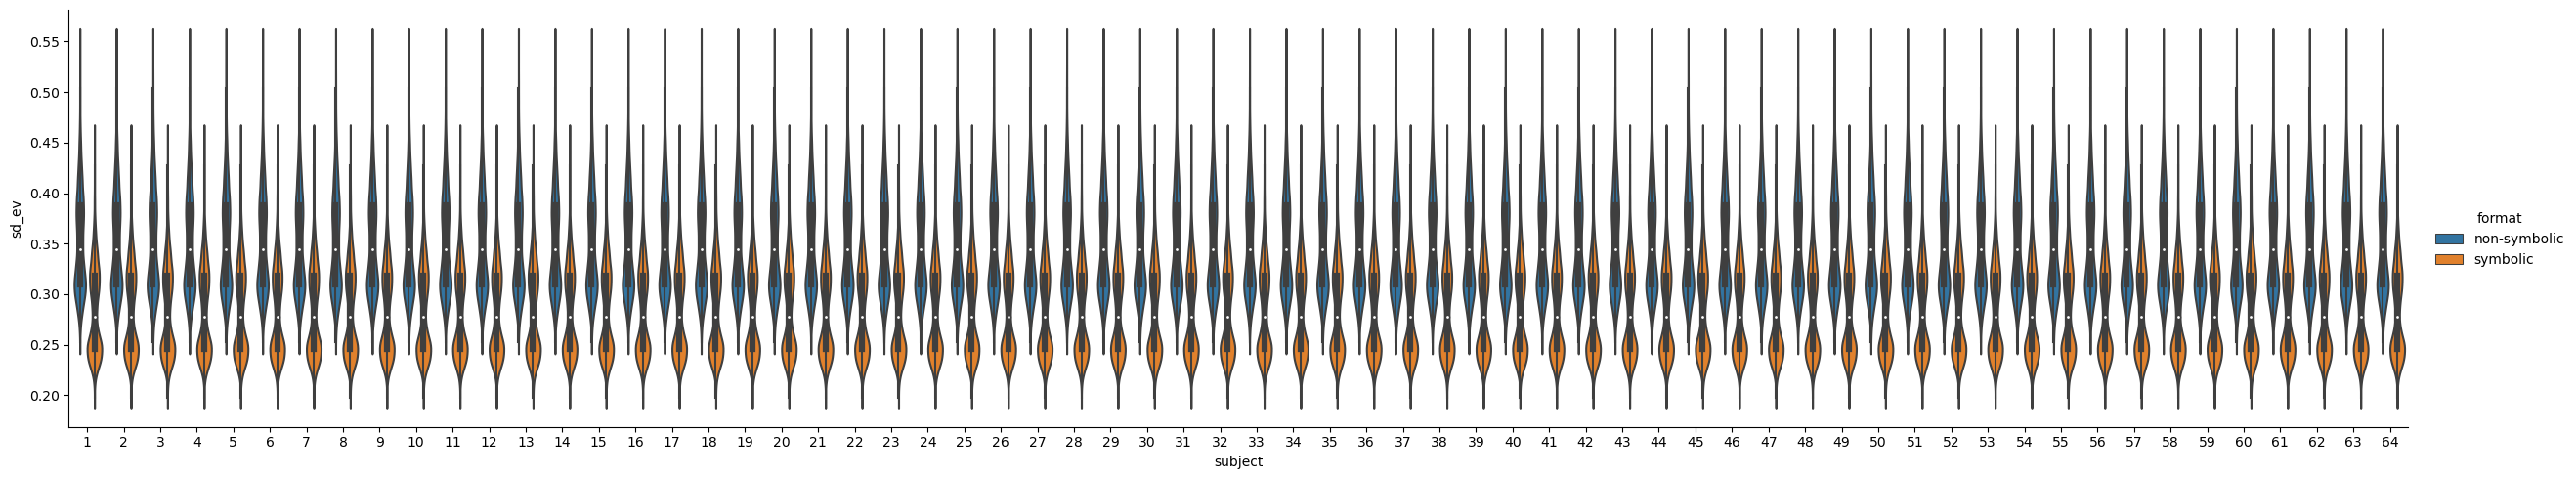

In [49]:
fac = sns.catplot(x='subject', y='sd_ev', data=df_klw_params.reset_index(), hue='format', aspect=5., kind='violin')
